In [69]:
import pandas as pd
import os
import soundfile as sf
import argparse
import librosa
import numpy as np
import scipy as sp
import scipy.signal
import scipy.stats
import webrtcvad
import collections
import contextlib
import struct
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import skimage

In [70]:
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


def run_vad(data, aggress=2, window_duration=0.03, samplerate=16000):
    vad = webrtcvad.Vad()
    vad.set_mode(aggress)
    audio = float2pcm(data)
    raw_samples = struct.pack("%dh" % len(audio), *audio)
    samples_per_window = int(window_duration * samplerate)
    number_windows = int(np.floor(len(audio) / samples_per_window))
    bytes_per_sample = 2

    segments = []
    for i in np.arange(number_windows):
        raw_frame = raw_samples[i * bytes_per_sample * samples_per_window:
                                (i + 1) * bytes_per_sample * samples_per_window]
        is_speech = vad.is_speech(raw_frame, sample_rate=samplerate)
        segments.append(dict(
            start = i * samples_per_window,
            stop = (i + 1) * samples_per_window - 1,
            is_speech=is_speech))

    old_bool = segments[0]['is_speech']
    new_start = segments[0]['start']

    long_segments = []
    for i, segment in enumerate(segments):
        new_bool = segment['is_speech']
        if old_bool == new_bool:
            new_stop = segment['stop']
        else:
            long_segments.append(dict(
                start=new_start,
                stop=new_stop,
                is_speech=old_bool))
            new_start = segment['start']
            new_stop = segment['stop']
        old_bool = new_bool
        if i == len(segments) - 1:
            long_segments.append(dict(
                start=new_start,
                stop=new_stop,
                is_speech=old_bool))
    return long_segments

In [71]:
def compute_lpc(audio, len_lpc, window_length_sec=0.025, samplerate=16000):
    len_lpc = int(len_lpc)
    window_length = int(window_length_sec * samplerate)
    win_number = int(np.floor(len(audio) / window_length))

    coeff = np.zeros((win_number, len_lpc + 1))
    frames = np.zeros((win_number, window_length - 2 * len_lpc - 2))
    res = np.zeros((win_number, window_length - 2 * len_lpc - 2))
    count = 0
    for i in np.arange(win_number):
        frame = audio[i * window_length:(i + 1) * window_length]

        try:
            a = librosa.lpc(frame, len_lpc)
        except:
            count = count + 1
            coeff[i, :] = np.nan
            res[i, :] = np.nan
            frames[i, :] = np.nan
            continue

        coeff[i, :] = a
        frames[i, :] = frame[len_lpc + 1:-len_lpc - 1]
        res_frame = np.asarray(scipy.signal.lfilter(a, [1], frame))
        res[i, :] = res_frame[len_lpc + 1:-len_lpc - 1]

    if count != 0:
        print('{} not valid frames from LPC'.format(count))
    #res = res[~np.isnan(res).any(axis=1)]
    #coeff = coeff[~np.isnan(coeff).any(axis=1)]
    # here I want to remove the samples where res is not valid (for computing gain I need them to be synchronized)
    #frames = frames[~np.isnan(frames).any(axis=1)]

    return res, coeff, frames


def compute_lpc(audio, len_lpc, window_length_sec=0.025, samplerate=16000):
    len_lpc = int(len_lpc)
    window_length = int(window_length_sec * samplerate)
    win_number = int(np.floor(len(audio) / window_length))

    coeff = np.zeros((win_number, len_lpc + 1 ))
    frames = np.zeros((win_number, window_length - 2 * len_lpc - 2))
    res = np.zeros((win_number, window_length - 2 * len_lpc - 2))
    for i in np.arange(win_number):
        frame = audio[i * window_length:(i + 1) * window_length]
        try:
            a = librosa.lpc(frame, len_lpc)
        except:
            coeff[i, :] = np.nan
            res[i, :] = np.nan
            frames[i, :] = np.nan
            continue
        coeff[i, :] = a
        frames[i, :] = frame[len_lpc + 1:-len_lpc - 1]
        res_frame = np.asarray(scipy.signal.lfilter(a, [1], frame))
        res[i, :] = res_frame[len_lpc + 1:-len_lpc - 1]
    res = res[~np.isnan(res).any(axis=1)]
    coeff = coeff[~np.isnan(coeff).any(axis=1)]
    frames = frames[~np.isnan(frames).any(axis=1)]

    return res, coeff, frames



In [72]:
def compute_ltp(err, samplerate=16000, analysis_frame_length_sec=0.005):
    analysis_frame_length = int(np.round(analysis_frame_length_sec * samplerate))
    win_number = int(np.floor(len(err) / analysis_frame_length))
    p_min = int(np.round(0.00625 * samplerate))
    p_max = int(np.round(0.025 * samplerate))

    best_res = []
    lpc_err = []

    count = 0
    for i in np.arange(win_number):

        current_start_index = int(i * analysis_frame_length)

        if current_start_index < p_max:
            continue

        if np.any(np.isnan(err[current_start_index - p_max: current_start_index + analysis_frame_length])):
            count = count + 1
            continue

        shifted_frame = err[current_start_index - p_max: current_start_index - p_min + analysis_frame_length]
        current_frame = err[current_start_index: current_start_index + analysis_frame_length]

        b_num = np.correlate(shifted_frame, current_frame, mode='valid')
        b_den = np.correlate(shifted_frame ** 2, np.ones((analysis_frame_length,)), mode='valid')

        b = np.divide(b_num, b_den + np.finfo(float).eps)

        current_frame_rep = np.tile(current_frame, (p_max - p_min + 1, 1))
        scaled_shifted_frame = skimage.util.view_as_windows(shifted_frame, analysis_frame_length,
                                                            step=1) * np.expand_dims(b, axis=1)
        J = np.sum((current_frame_rep - scaled_shifted_frame) ** 2, axis=1)
        m_opt = np.argmin(J)

        best_res.append(current_frame - scaled_shifted_frame[m_opt, :])
        lpc_err.append(current_frame)
    if count != 0:
        print('In this audio {} not valid frames of 0.005 sec were found'.format(count))
    return np.asarray(best_res), np.asarray(lpc_err)

## call this on the residual of each frame of 25 msec
def compute_ltp(err, fs, analysis_frame_length_sec=0.005):
    
    analysis_frame_length = int(np.round(analysis_frame_length_sec * fs))
    win_number = int(np.floor(len(err) / analysis_frame_length))
    p_min = int(np.round(0.00625 * fs)) 
    p_max = int(np.round(0.025 * fs))  
    
    
    J_min = np.ones((win_number,)) * 10e9
    M_opt = np.zeros((win_number,))
    b_opt = np.zeros((win_number,))
    best_res = []
    lpc_err = []
    
    for i in np.arange(win_number):
        
        current_start_index = int(i * analysis_frame_length) #bs
        
        if current_start_index < p_max:
            #best_res.append(np.zeros((analysis_frame_length,)))
            continue
        
        for m in np.arange(p_max, p_min, -1):
            b_num = np.sum(err[current_start_index : current_start_index + analysis_frame_length] *
                err[current_start_index - m : current_start_index - m + analysis_frame_length])
            b_den = np.sum(err[current_start_index - m : current_start_index - m + analysis_frame_length] ** 2)
           
            b = b_num / b_den

            J_1 = err[current_start_index : current_start_index + analysis_frame_length]
            J_2 = b * err[current_start_index - m : current_start_index - m + analysis_frame_length]

            J = np.sum((J_1 - J_2) ** 2)
            
            if J < J_min[i]:
                J_min[i] = J
                M_opt[i] = m
                best_J_1 = J_1
                best_J_2 = J_2

        best_res.append(best_J_1 - best_J_2)
        lpc_err.append(err[current_start_index : current_start_index + analysis_frame_length])
    
    return np.asarray(best_res), np.asarray(lpc_err)

def compute_ltp_fast(err, samplerate=16000, analysis_frame_length_sec=0.005):
    analysis_frame_length = int(np.round(analysis_frame_length_sec * samplerate))
    win_number = int(np.floor(len(err) / analysis_frame_length))
    p_min = int(np.round(0.00625 * samplerate))
    p_max = int(np.round(0.025 * samplerate))

    best_res = []
    lpc_err = []
    
    count = 0
    for i in np.arange(win_number):

        current_start_index = int(i * analysis_frame_length)

        if current_start_index < p_max:
            continue

        if np.any(np.isnan(err[current_start_index - p_max : current_start_index + analysis_frame_length])):
            count = count + 1
            continue

        shifted_frame = err[current_start_index - p_max : current_start_index - p_min + analysis_frame_length]
        current_frame = err[current_start_index: current_start_index + analysis_frame_length]

        b_num = np.correlate(shifted_frame, current_frame, mode='valid')
        b_den = np.correlate(shifted_frame**2, np.ones((analysis_frame_length,)), mode='valid')

        b = np.divide(b_num, b_den)
        
        current_frame_rep = np.tile(current_frame, (p_max - p_min + 1, 1))
        scaled_shifted_frame = skimage.util.view_as_windows(shifted_frame, analysis_frame_length, 
                                                            step=1) * np.expand_dims(b, axis=1)
        J = np.sum((current_frame_rep - scaled_shifted_frame)**2, axis=1) 
        m_opt = np.argmin(J)
        
        best_res.append(current_frame - scaled_shifted_frame[m_opt, :])
        lpc_err.append(current_frame)
    if count != 0:
        print('In this audio {} not valid frames of 0.005 sec were found'.format(count))
    return np.asarray(best_res), np.asarray(lpc_err)

In [88]:
audio_folder = '/nas/home/cborrelli/bot_speech/notebook/audio' 
audio_filename = 'voiced_a.wav'


data, samplerate = sf.read(os.path.join(audio_folder, audio_filename))


res, coeff, frames = compute_lpc(data, len_lpc=10, window_length_sec=0.025, samplerate=samplerate)

ltp_res, ltp_frames = compute_ltp(res.ravel(), samplerate)


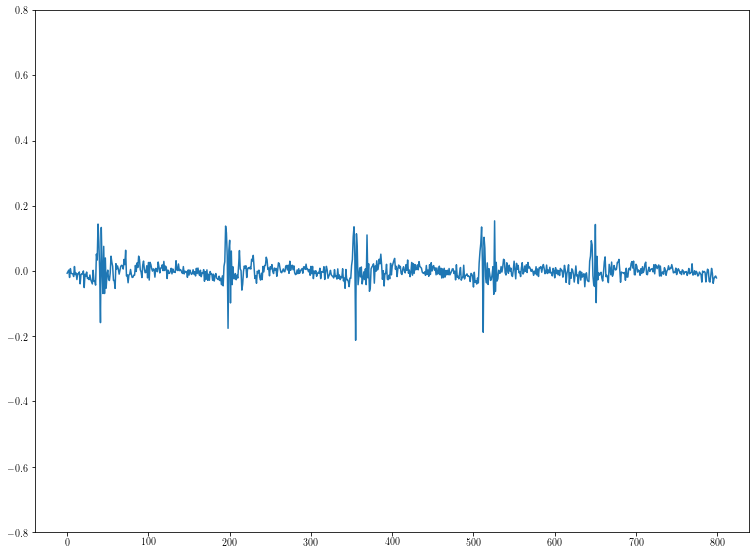

In [119]:
import IPython.display as ipd
plt.figure(figsize=(6.4*2, 4.8*2))
plt.plot(res.ravel()[:800])
plt.ylim((-0.8, 0.8))
ipd.Audio(data, rate=samplerate)

/nas/home/cborrelli/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


(-0.1, 1.1)

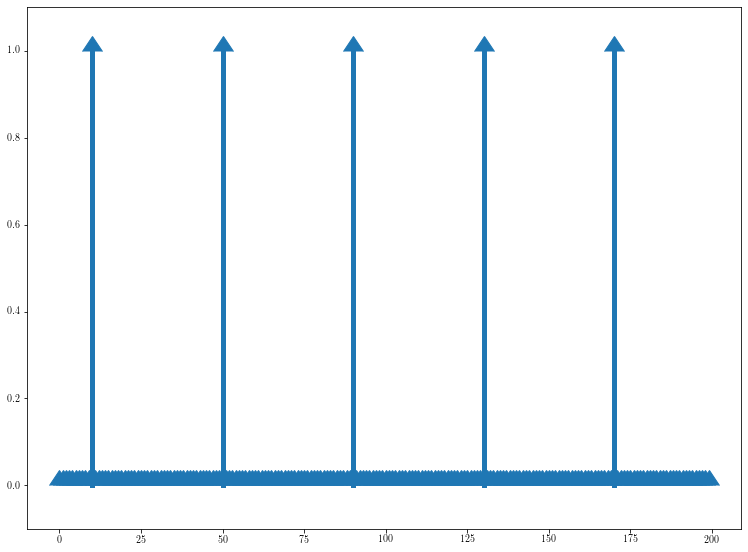

In [147]:
from scipy import signal
import matplotlib
impulse_train = signal.unit_impulse(200, [10,50, 90])

impulse_train = np.zeros((200))
impulse_train[10] = 1
impulse_train[50] = 1
impulse_train[90] = 1
impulse_train[130] = 1
impulse_train[170] = 1

plt.figure(figsize=(6.4*2, 4.8*2))
markerline, stemlines, _ = plt.stem(impulse_train, use_line_collection=False, basefmt=" ")
plt.setp(stemlines, 'linewidth', 5)
plt.setp(markerline, 'marker', matplotlib.markers.CARETUPBASE, 'markersize', 20)

plt.ylim((-0.1, 1.1))

(-2, 2)

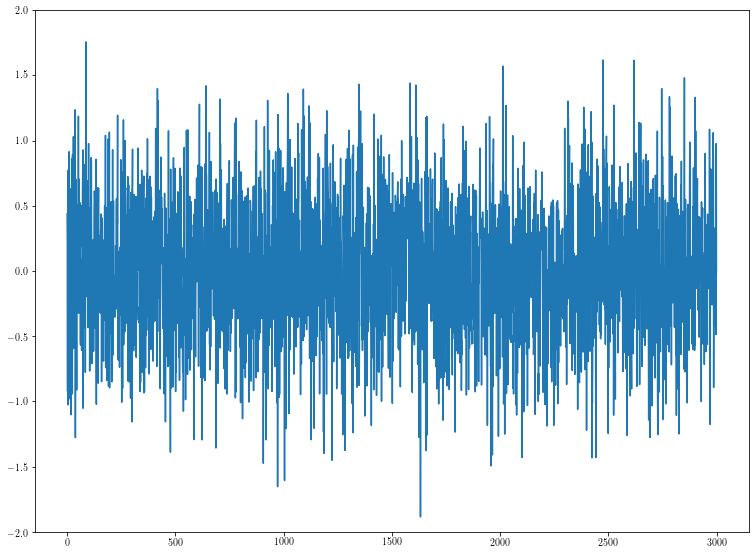

In [160]:
from scipy import signal
import matplotlib

mean = 0
std = 0.5 
num_samples = 3000
white_noise = np.random.normal(mean, std, size=num_samples)

plt.figure(figsize=(6.4*2, 4.8*2))
plt.plot(white_noise)


plt.ylim((-2, 2))

## PLOT

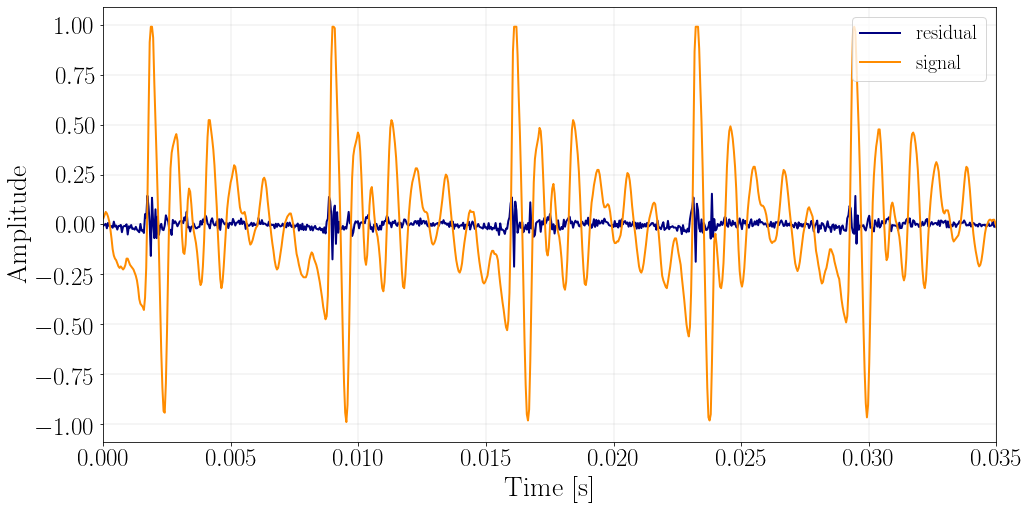

In [110]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = 'true'
plt.figure(figsize=(16,8))
time_axis = np.arange(len(res.ravel())) / samplerate
plt.plot(time_axis, res.ravel(), color='navy', lw=2, label="residual")
plt.plot(time_axis,frames.ravel(), color='darkorange', lw=2,label="signal")
plt.grid()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(linewidth=0.25)
plt.xlabel("Time [s]", fontsize=28)
plt.ylabel("Amplitude", fontsize=28)
plt.xlim((-0.0000,0.035))
plt.legend(fontsize=20)

plt.show()

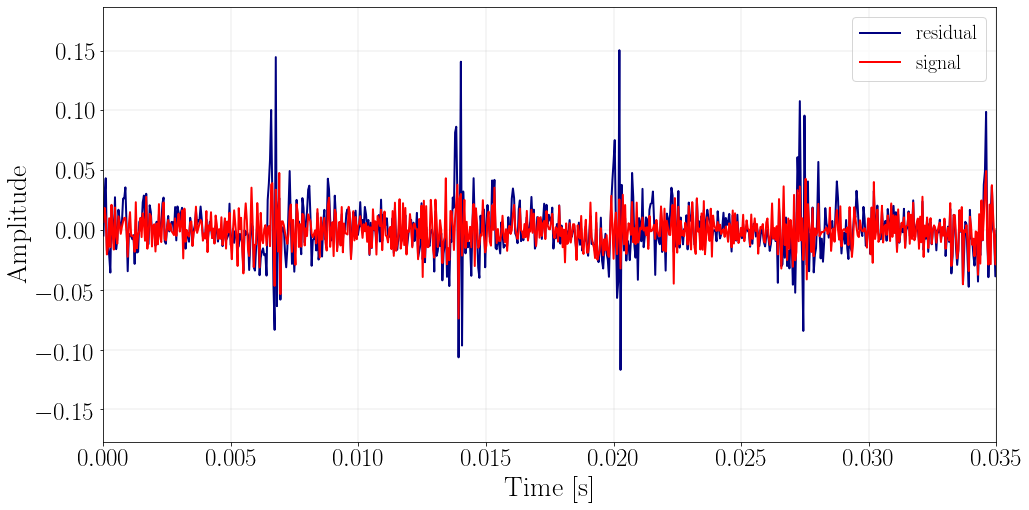

In [111]:
plt.figure(figsize=(16,8))
time_axis = np.arange(len(ltp_frames.ravel())) / samplerate
plt.plot(time_axis, ltp_frames.ravel(), color='navy', lw=2, label="residual")
plt.plot(time_axis,ltp_res.ravel(), color='red', lw=2,label="signal")
plt.grid()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(linewidth=0.25)
plt.xlabel("Time [s]", fontsize=28)
plt.ylabel("Amplitude", fontsize=28)
plt.xlim((-0.0000,0.035))
plt.legend(fontsize=20)

plt.show()